<h1 style="text-align: center; ">Проект №2</h1>

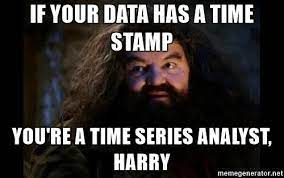

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from operator import itemgetter

In [3]:
ts = pd.read_csv('Project_dataset.csv', parse_dates=['Date'], index_col='Date')

### Посмотрим на временной ряд

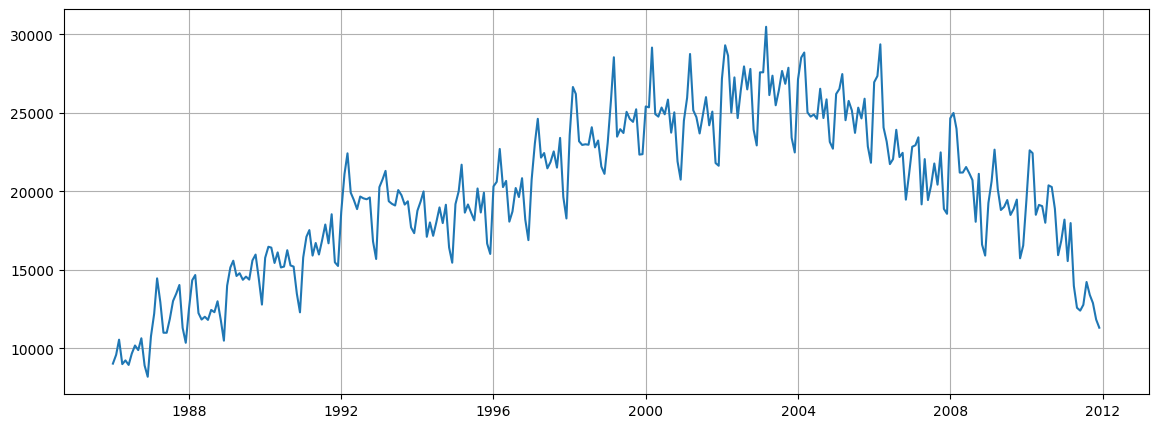

In [4]:
plt.figure(figsize=(14, 5))
plt.plot(ts)
plt.grid()
plt.plot()
plt.show()

### Исследуем свойства ряда

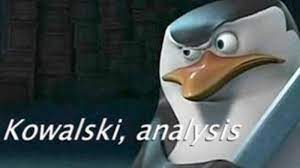

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [1]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    plt.figure(figsize=(14, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

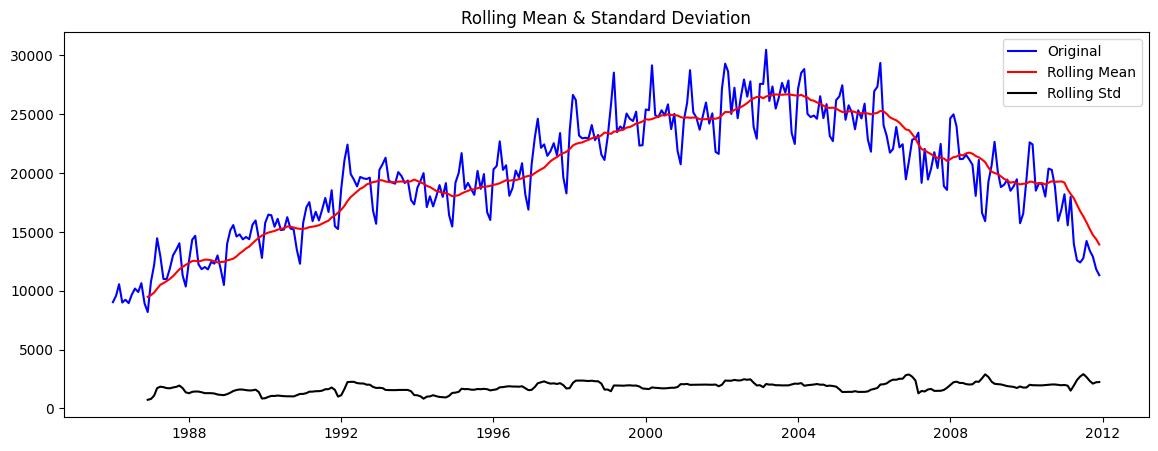

In [7]:
test_stationarity(ts)

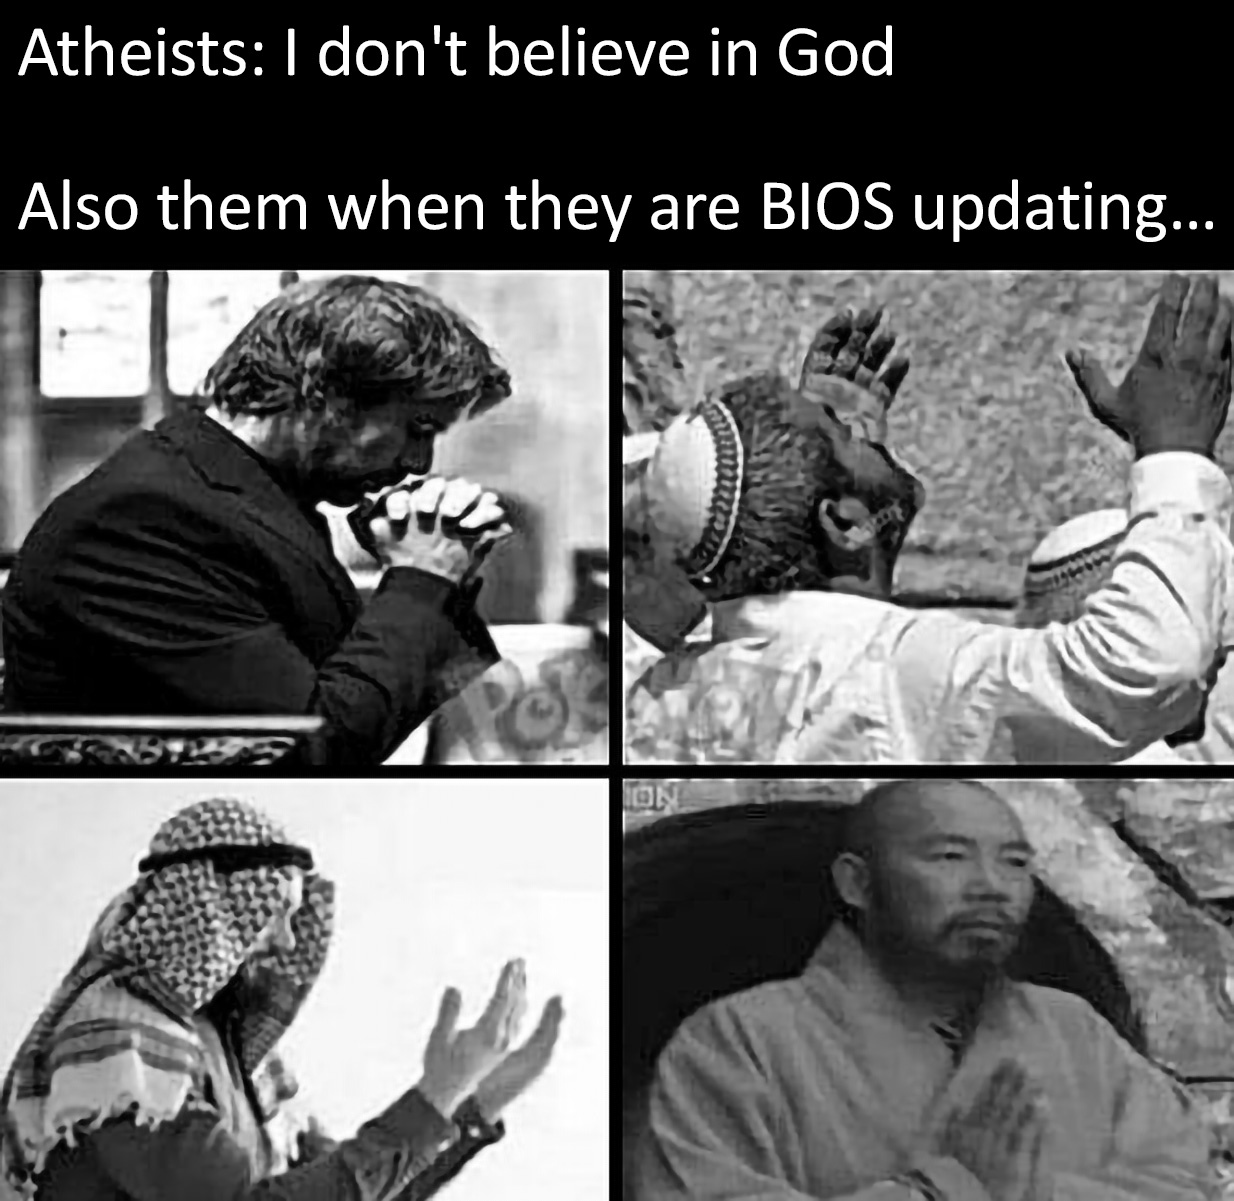

### Посмотрим STL-разложение ряда

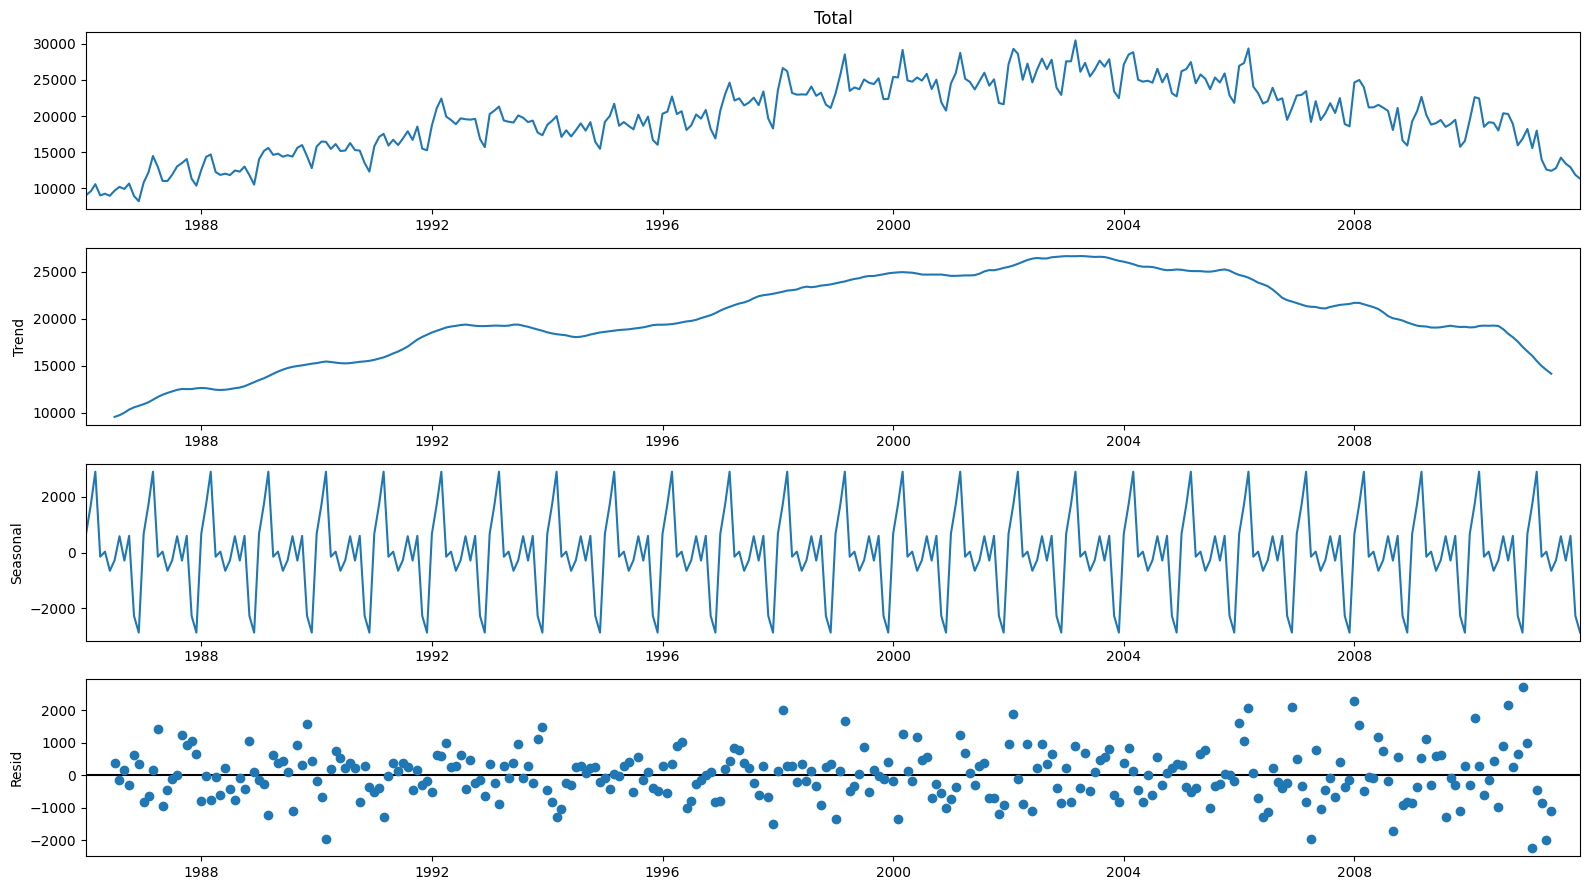

In [8]:
def decomposition(ts):
    decomp_viz = seasonal_decompose(ts, period=12)
    fig = decomp_viz.plot()
    fig.set_size_inches((16, 9))
    fig.tight_layout()
    plt.show()

decomposition(ts.Total)

Видим, что у нашего ряда есть тренд. При этом сначала он увеличивается, а потом уменьшается. Также видна сезонность, поэтому в дальнейшем для предсказания будем брать модели, учитывающие сезонность. На нижнем графике кажется дисперсия чуть увеличивается к концу. Попробуем применить стабилизацию дисперсии и посмотреть, что получится

Оптимальный параметр преобразования Бокса-Кокса: 1.308367
Критерий Дики-Фуллера: p=0.734890


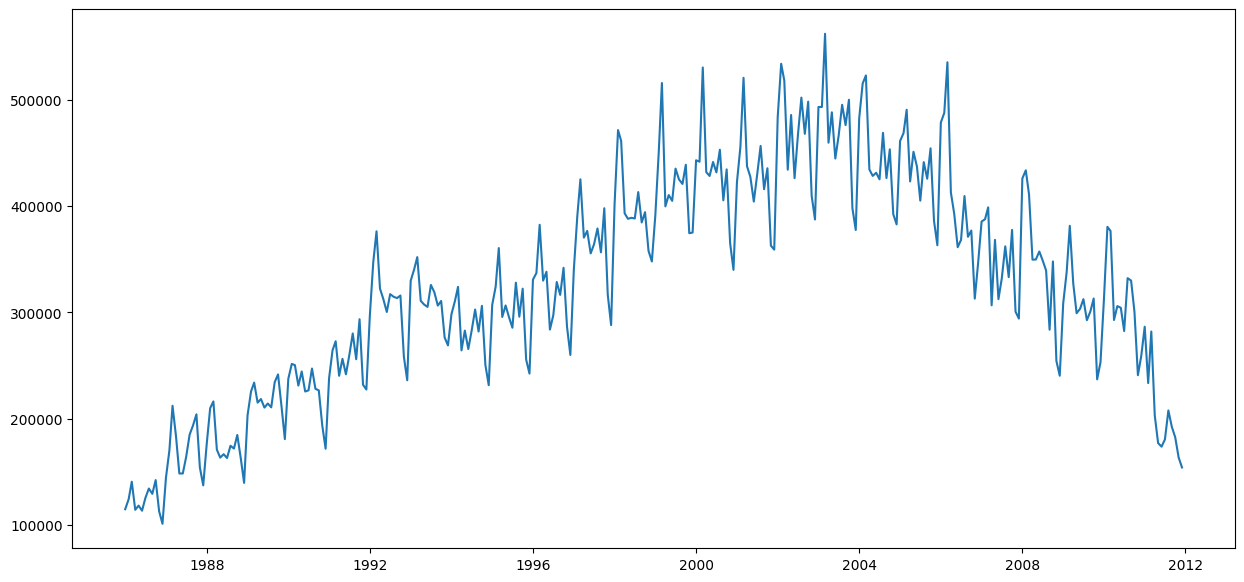

In [9]:
ts['total_box'], lmbda = stats.boxcox(ts.Total)
plt.figure(figsize=(15,7))
plt.plot(ts['total_box'])
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts.total_box)[1])

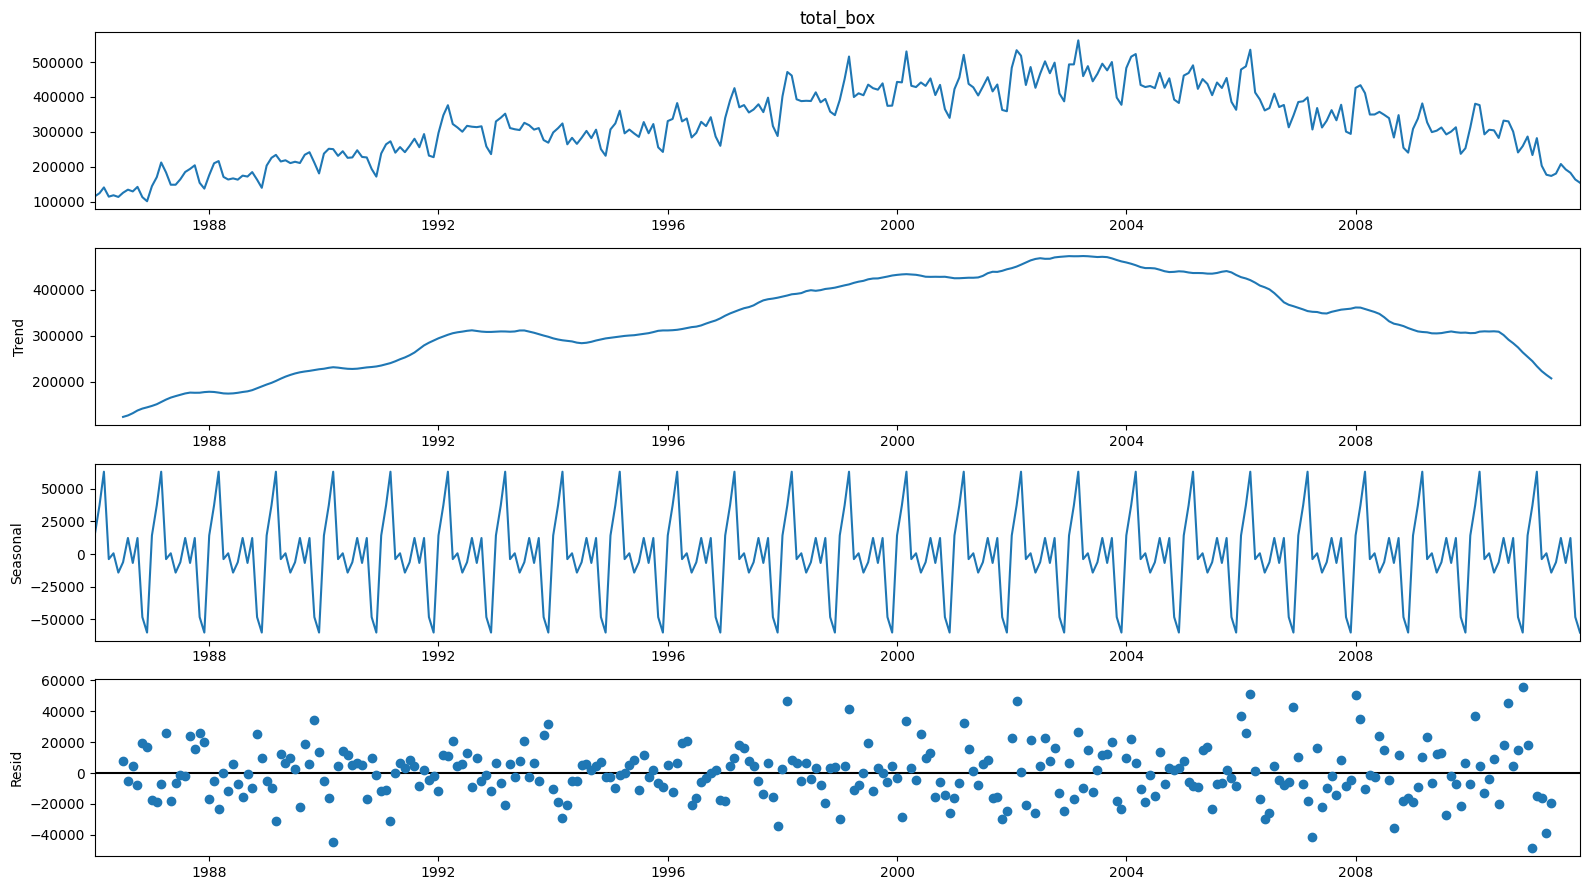

In [10]:
decomposition(ts['total_box'])

Визуально ничего не изменилось, кроме масштаба, но p-value чуть уменьшился. Возьмем преобразованные данные, так как хуже точно не будет
Интересно, что по критерию Дики-Фуллера у нас ряд стационарен, но по графику мы видим, что это не так. 

### Взятие разностей

Попробуем привести ряд к стационарому виду  
Для начала избавися от сезонности

Критерий Дики-Фуллера: p=0.451930


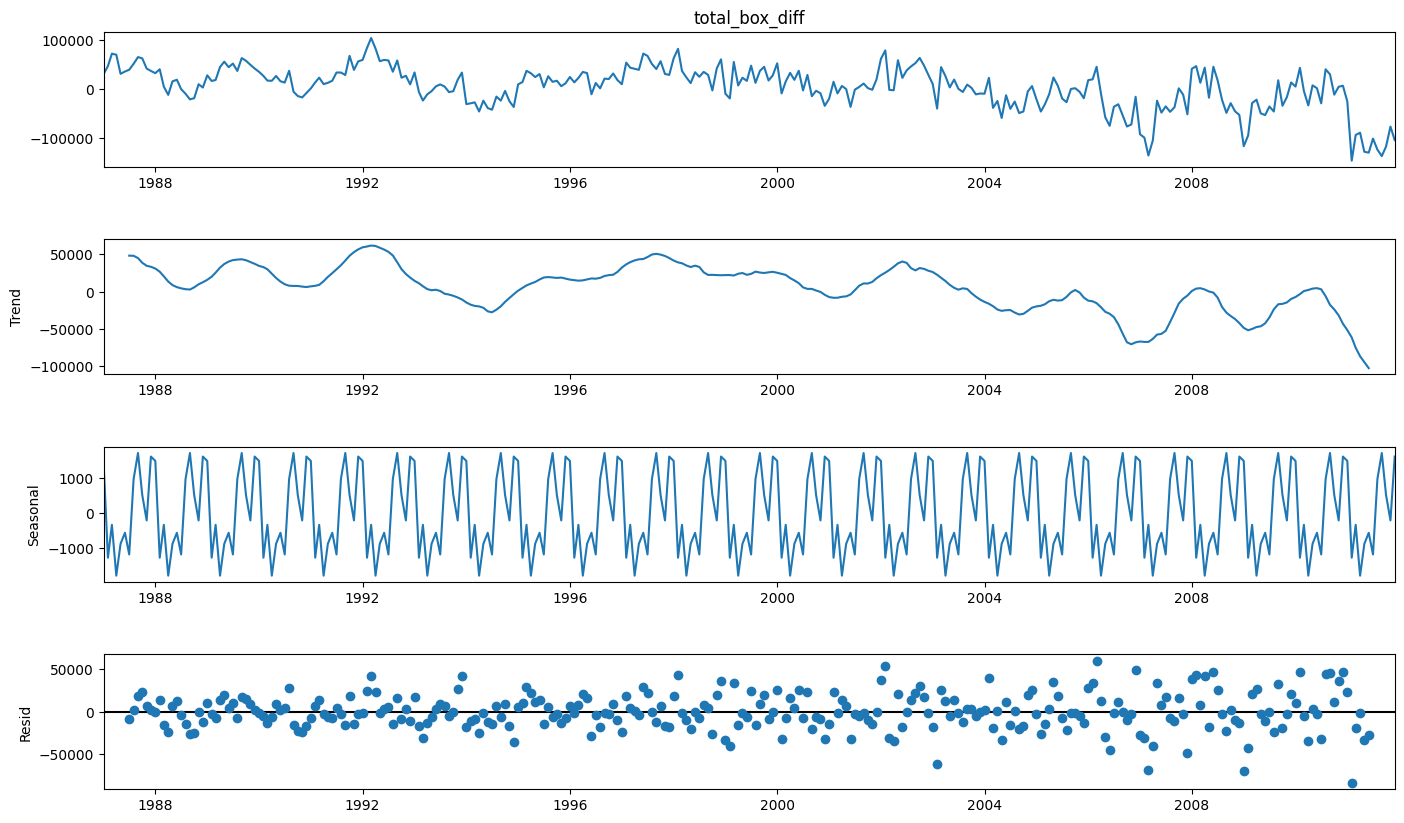

In [11]:
ts['total_box_diff'] = ts.total_box - ts.total_box.shift(12)
sm.tsa.seasonal_decompose(ts.total_box_diff[12:]).plot().set_size_inches((16, 9))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts.total_box_diff[12:])[1])

Уже лучше, теперь посмотрим на первые разности

Критерий Дики-Фуллера: p=0.000000


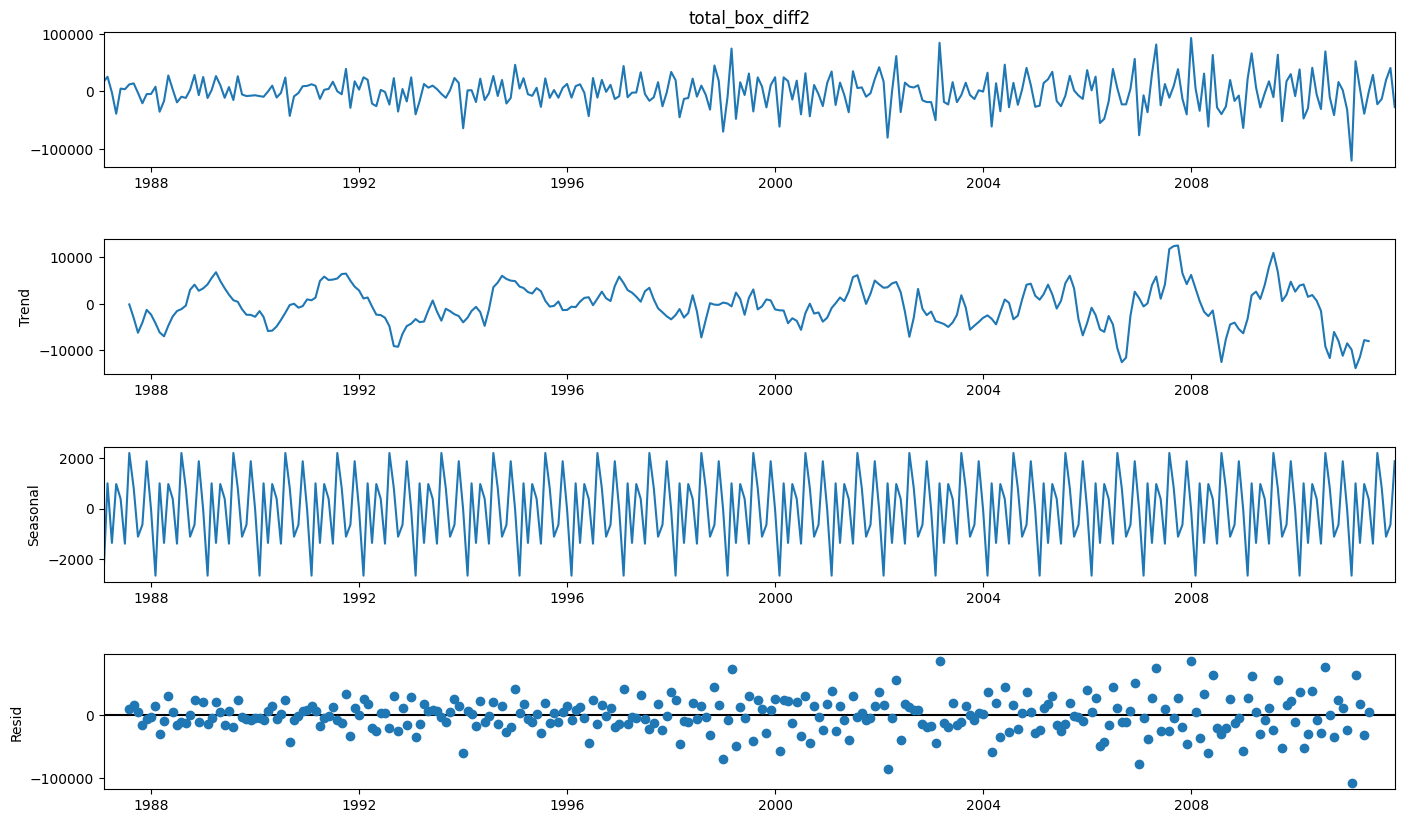

In [12]:
ts['total_box_diff2'] = ts.total_box_diff - ts.total_box_diff.shift(1)
sm.tsa.seasonal_decompose(ts.total_box_diff2[13:]).plot().set_size_inches((16, 9))   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts.total_box_diff2[13:])[1])

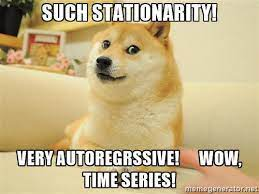

Отлично! Получили стационарный ряд. Получается, что для дальнейшей модели будем использовать d = 1 и D = 1

Ниже написали функцию, которая определяет порядок разностей автоматически без анализа графиков

In [13]:
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage import shift

def get_stationary(timeSeries, ad_fuller_p_value_level=0.05):    
    timeSeries = timeSeries.values
    
    nan_inds = np.unique(np.argwhere(np.isnan(timeSeries))[:, 0])
    timeSeries = np.delete(timeSeries, nan_inds)
    x1 = timeSeries
    lost_values = []
    
    
    if (adfuller(x1)[1] > ad_fuller_p_value_level):
        lost_values.append(x1[0])
        x1 = (x1 - shift(x1, 1, cval=np.nan))[1:]

    if (adfuller(x1)[1] > ad_fuller_p_value_level):
        lost_values.append(x1[0])
        x1 = (x1 - shift(x1, 1, cval=np.nan))[1:]

    assert adfuller(x1)[1] <= ad_fuller_p_value_level
    
    return x1, lost_values

In [14]:
stat_ts, lost_values = get_stationary(ts['Total'])

In [15]:
stat_ts = pd.Series(stat_ts, index=ts.index[1:])

In [16]:
# порядок дифференцирования потребовавшийся для приведения к стационарности
# это и будет аргумент d который подставим в ARIMA
len(lost_values)

1

In [17]:
# возврат от дифференцированного ряда к обычному, на всякий случай
# np.cumsum(lost_values + list(stat_ts))

### Подбор модели

Построим графики ACF и PACF

In [18]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

/Users/r.berdyshev/Library/Python/3.9/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


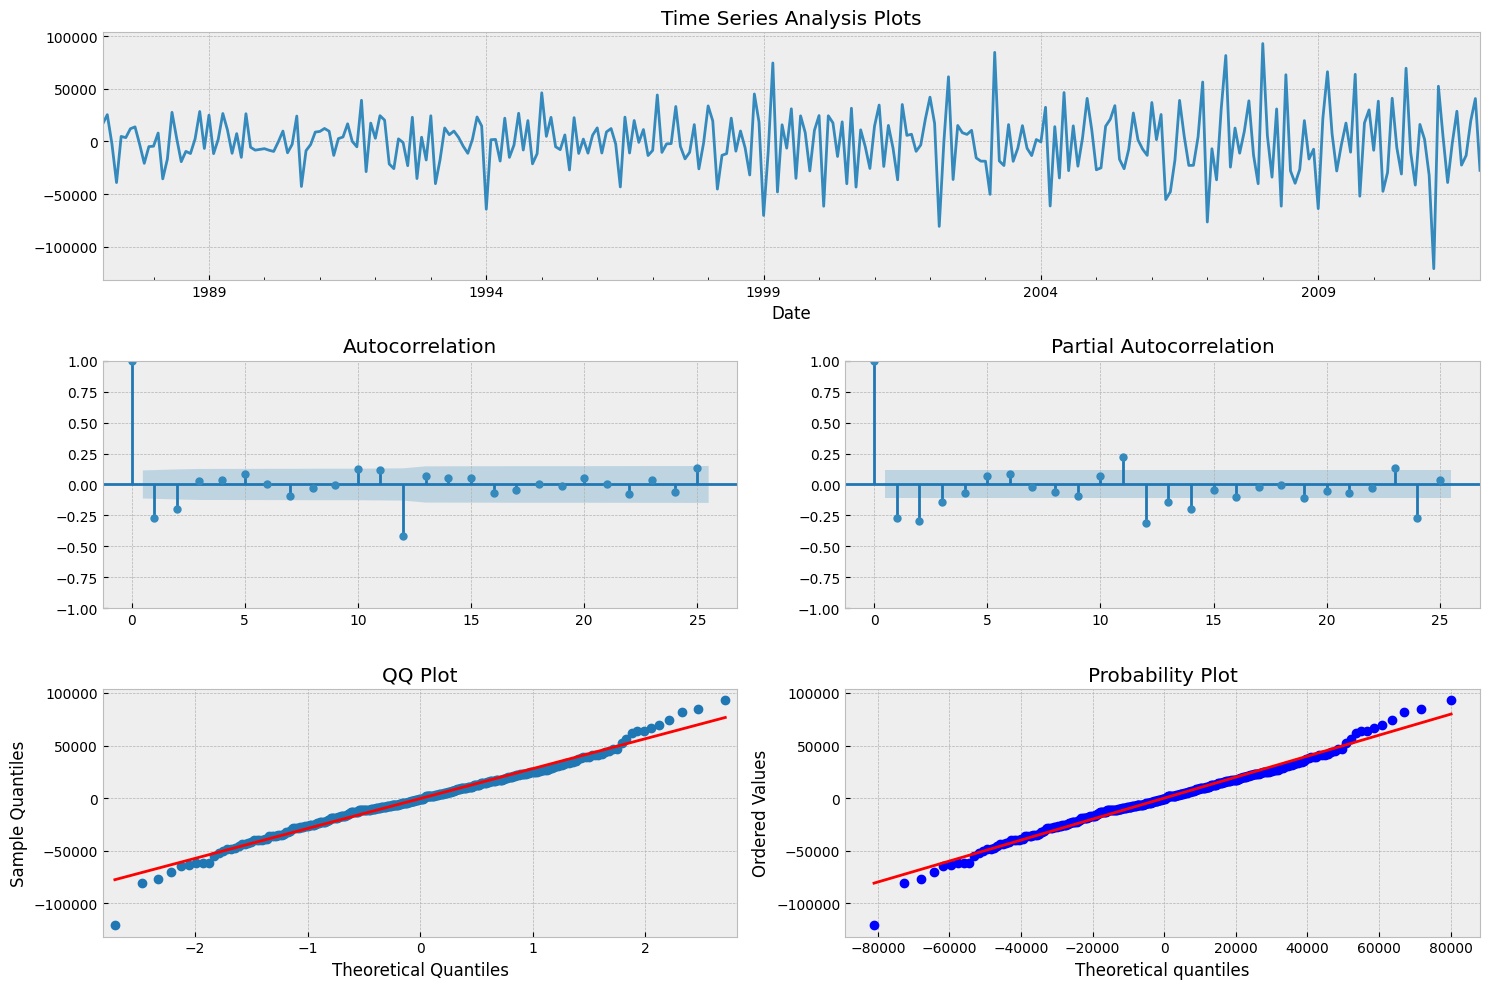

In [19]:
tsplot(ts.total_box_diff2[13:])

Из графиков acf и pacf можем получить начальные приближения для нашей будущей модели: q = 2, p = 3

###  Обучение модели и подбор параметров

**Обоснование выбора модели**: Мы видели наличие сезонности в ряде, поэтому использовать будем модель SARIMA - эта модель может учесть все найденные свойства и нестационарности ряда

In [20]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [22]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [30]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(ts['total_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2min 10s, sys: 1min 1s, total: 3min 12s
Wall time: 34.5 s


In [31]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
29  (2, 1, 0, 1)  6837.489214
37  (3, 0, 0, 1)  6838.028260
49  (4, 0, 0, 1)  6838.217738
31  (2, 1, 1, 1)  6839.392224
41  (3, 1, 0, 1)  6839.456234


In [32]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          total_box   No. Observations:                  312
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3413.745
Date:                            Sun, 26 Feb 2023   AIC                           6837.489
Time:                                    15:58:27   BIC                           6855.991
Sample:                                01-01-1986   HQIC                          6844.895
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0424      0.241     -0.176      0.860      -0.514       0.429
ar.L2         -0.1927      0.118   

### Проверка модели на адекватность

Критерий Стьюдента: p=0.162896
Критерий Дики-Фуллера: p=0.000000


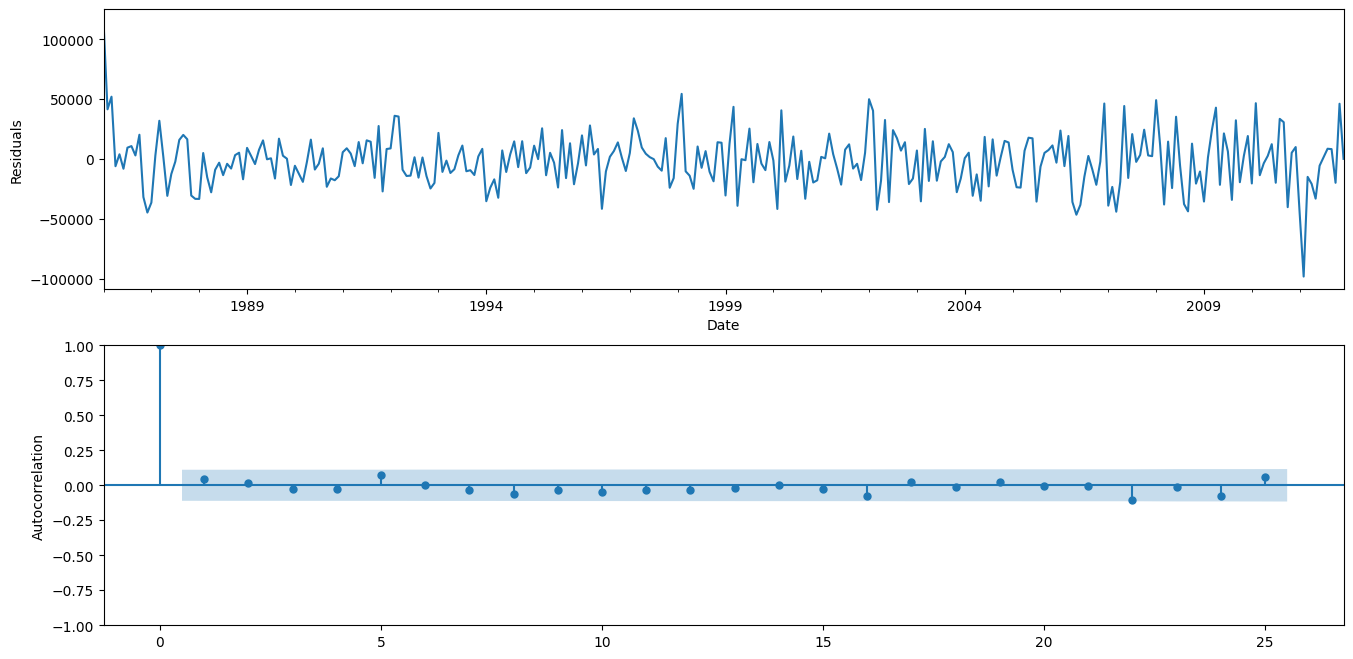

In [33]:
plt.figure(figsize=(16,8))
plt.subplot(211)
best_model.resid[:].plot() 
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[:].values.squeeze(), ax=ax, title='')
plt.ylabel('Autocorrelation')

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[:])[1])

Остатки несмещены (по критерию Стьюдента), стационарны(по критерию Дики-Фуллера) и неавтокоррелированы

### Предсказание

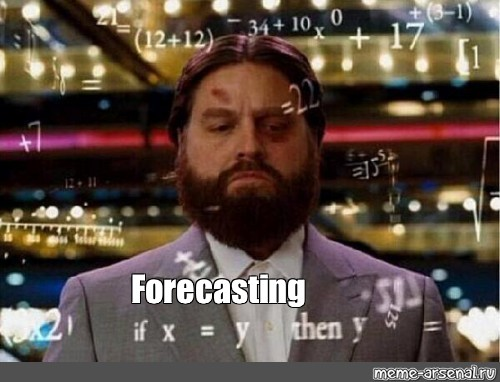

In [34]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

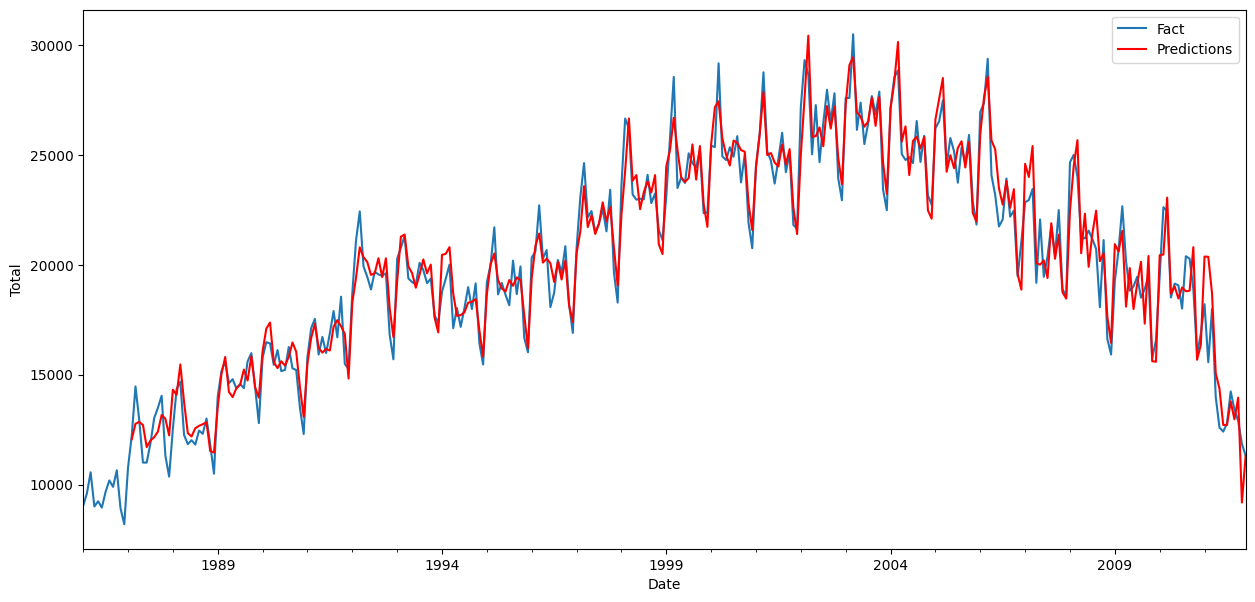

In [41]:
pred = invboxcox(best_model.fittedvalues, lmbda) #делаем обратное преобразование бокса-кокса
ts['model'] = pred
plt.figure(figsize=(15,7))
ts['Total'].plot(label='Fact')
ts.model[13:].plot(color='r', label='Predictions')
plt.ylabel('Total')
plt.legend()
plt.show()

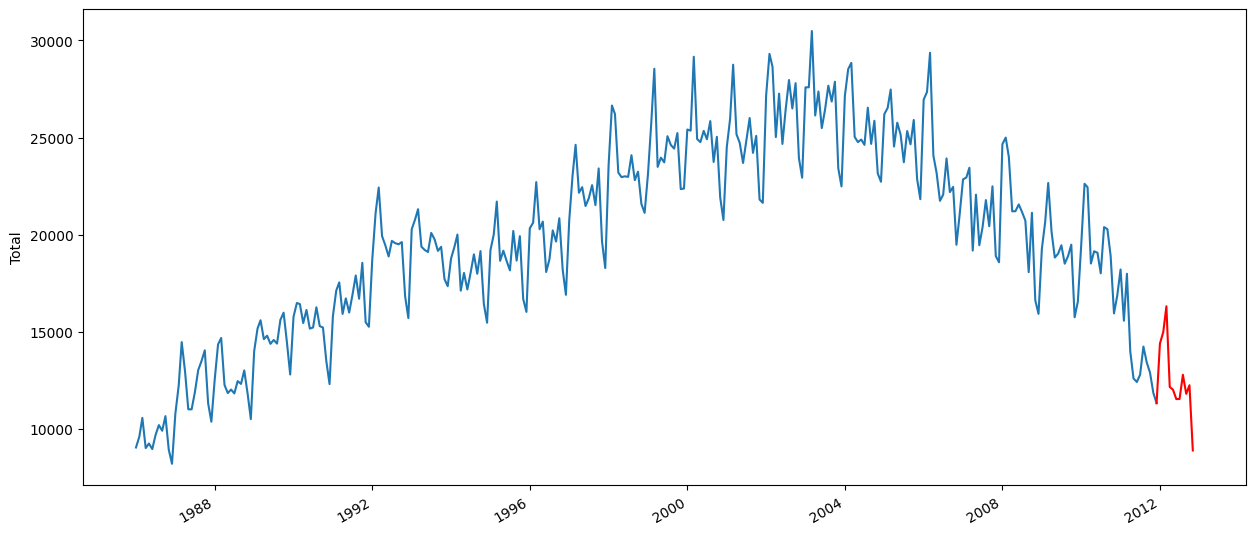

In [38]:
import datetime
from dateutil.relativedelta import relativedelta
ts2 = ts[['Total']]
date_list = [datetime.datetime.strptime("2011-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= ts.columns)
ts2 = pd.concat([ts2, future])
ts2['forecast'] = invboxcox(best_model.predict(start=311, end=324), lmbda)

plt.figure(figsize=(15,7))
ts2['Total'].plot()
ts2.forecast.plot(color='r')
plt.ylabel('Total')
plt.show()

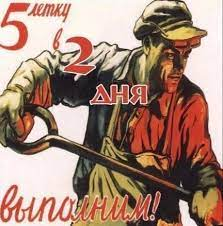